# Imports

In [12]:
import os
import sys
import subprocess
import random
import zipfile
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

try:
    from pycocotools.coco import COCO
except ImportError:
    COCO = None

try:
    import wget
except ImportError:
    wget = None

try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    drive = None
    IN_COLAB = False

train_images_dir = None
val_images_dir = None
annotations_dir = None
train_ann_file = None
val_ann_file = None
data_dir = None

# Phase 1: Data Processing Pipeline

This notebook builds a **data processing pipeline** for Human Pose Estimation with the COCO dataset. It covers:

1. **Setup & Dependencies**
2. **Data Download & Organization**
3. **Dataset & DataLoader Implementation**
4. **Keypoint-Aware Augmentation**
5. **Visualization & Validation**

## Step 1: Environment Setup & Dependencies

In [13]:
def setup_environment():
    global COCO, wget, drive

    packages_to_install = []

    if COCO is None:
        packages_to_install.append('pycocotools')
    if wget is None:
        packages_to_install.append('wget')
    packages_to_install.extend(['opencv-python', 'matplotlib'])

    if packages_to_install:
        for package in packages_to_install:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

    if COCO is None:
        from pycocotools.coco import COCO
        globals()['COCO'] = COCO

    if wget is None:
        import wget
        globals()['wget'] = wget

    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    return True

setup_success = setup_environment()

## Step 2: Data Download & Preparation

In [14]:
def prepare_data_directories():
    global data_dir, train_images_dir, val_images_dir, annotations_dir, train_ann_file, val_ann_file

    if drive is not None:
        try:
            drive.mount('/content/drive')
            data_dir = "/content/drive/MyDrive/ColabDataset/coco_full"
        except:
            data_dir = "./coco_data"
    else:
        data_dir = "./coco_data"

    Path(data_dir).mkdir(parents=True, exist_ok=True)

    urls = {
        "train2017": "http://images.cocodataset.org/zips/train2017.zip",
        "val2017": "http://images.cocodataset.org/zips/val2017.zip",
        "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    }

    def download_and_extract(name, url):
        zip_path = os.path.join(data_dir, f"{name}.zip")
        extract_path = os.path.join(data_dir, name)

        if os.path.exists(extract_path) and os.listdir(extract_path):
            return True

        if not os.path.exists(zip_path):
            if wget is not None:
                wget.download(url, zip_path)
            else:
                return False

        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(data_dir)
            return True
        except:
            return False

    success = True
    for key, url in urls.items():
        if not download_and_extract(key, url):
            success = False
            break

    if success:
        train_images_dir = os.path.join(data_dir, "train2017")
        val_images_dir = os.path.join(data_dir, "val2017")
        annotations_dir = os.path.join(data_dir, "annotations")
        train_ann_file = os.path.join(annotations_dir, "person_keypoints_train2017.json")
        val_ann_file = os.path.join(annotations_dir, "person_keypoints_val2017.json")

        critical_files = [train_ann_file, val_ann_file]
        missing_files = [f for f in critical_files if not os.path.exists(f)]

        if missing_files:
            return False

    return success

data_success = prepare_data_directories()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 3: Dataset Implementation

In [15]:
def create_dataset_classes():
    global COCODataset, get_dataloader

    class COCODataset(Dataset):
        def __init__(self, annotation_file, image_dir, transform=None):
            if not os.path.exists(annotation_file):
                raise FileNotFoundError(f"Annotation file {annotation_file} not found.")
            if not os.path.exists(image_dir):
                raise FileNotFoundError(f"Image directory {image_dir} not found.")

            self.coco = COCO(annotation_file)
            self.image_dir = image_dir
            self.transform = transform

            all_img_ids = self.coco.getImgIds(catIds=[1])
            self.img_ids = []
            for img_id in all_img_ids:
                img_info = self.coco.loadImgs(img_id)[0]
                img_path = os.path.join(self.image_dir, img_info['file_name'])
                if os.path.exists(img_path):
                    self.img_ids.append(img_id)

        def __len__(self):
            return len(self.img_ids)

        def __getitem__(self, idx):
            img_id = self.img_ids[idx]
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.image_dir, img_info['file_name'])
            img = cv2.imread(img_path)
            img = img[:, :, ::-1]

            orig_h, orig_w = img.shape[:2]
            img_resized = cv2.resize(img, (256, 256))

            ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=[1])
            anns = self.coco.loadAnns(ann_ids)

            keypoints_list = []
            for ann in anns:
                if 'keypoints' in ann and np.sum(ann['keypoints']) > 0:
                    kps = np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
                    keypoints_list.append(kps)
            keypoints = keypoints_list[0] if keypoints_list else np.zeros((17, 2))

            keypoints[:, 0] = keypoints[:, 0] * 256 / orig_w
            keypoints[:, 1] = keypoints[:, 1] * 256 / orig_h

            img_tensor = torch.tensor(img_resized).permute(2, 0, 1).float() / 255.0

            if self.transform is not None:
                img_tensor, keypoints = self.transform(img_tensor, keypoints)

            return img_tensor, keypoints

    def get_dataloader(annotation_file, image_dir, batch_size=4, transform=None):
        dataset = COCODataset(annotation_file, image_dir, transform=transform)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return COCODataset, get_dataloader

try:
    COCODataset, get_dataloader = create_dataset_classes()
    dataset_success = True
except Exception as e:
    dataset_success = False

## Step 4: Data Augmentation with Keypoint Transformations

In [16]:
def create_augmentation_transforms():
    global KeypointTransform, DebugTransform

    class KeypointTransform:
        def __init__(self, flip_prob=0.5, rotation_degrees=10, brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1):
            self.flip_prob = flip_prob
            self.rotation_degrees = rotation_degrees
            self.brightness = brightness
            self.contrast = contrast
            self.saturation = saturation
            self.hue = hue

        def __call__(self, image, keypoints):
            if torch.is_tensor(image):
                image = TF.to_pil_image(image)

            img_width, img_height = image.size
            was_flipped = False
            rotation_angle = 0

            if random.random() < self.flip_prob:
                image = TF.hflip(image)
                was_flipped = True

            if self.rotation_degrees > 0:
                rotation_angle = random.uniform(-self.rotation_degrees, self.rotation_degrees)
                image = TF.rotate(image, rotation_angle)

            if self.brightness > 0 or self.contrast > 0 or self.saturation > 0 or self.hue > 0:
                image = TF.adjust_brightness(image, 1 + random.uniform(-self.brightness, self.brightness))
                image = TF.adjust_contrast(image, 1 + random.uniform(-self.contrast, self.contrast))
                image = TF.adjust_saturation(image, 1 + random.uniform(-self.saturation, self.saturation))
                image = TF.adjust_hue(image, random.uniform(-self.hue, self.hue))

            image = TF.to_tensor(image)
            transformed_keypoints = keypoints.copy()

            if was_flipped:
                transformed_keypoints[:, 0] = img_width - 1 - transformed_keypoints[:, 0]
                swap_pairs = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
                for left_idx, right_idx in swap_pairs:
                    if left_idx < len(transformed_keypoints) and right_idx < len(transformed_keypoints):
                        transformed_keypoints[[left_idx, right_idx]] = transformed_keypoints[[right_idx, left_idx]]

            if abs(rotation_angle) > 0:
                center_x, center_y = img_width / 2, img_height / 2
                angle_rad = np.radians(-rotation_angle)
                cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

                x_centered = transformed_keypoints[:, 0] - center_x
                y_centered = transformed_keypoints[:, 1] - center_y

                x_rotated = x_centered * cos_angle - y_centered * sin_angle
                y_rotated = x_centered * sin_angle + y_centered * cos_angle

                transformed_keypoints[:, 0] = x_rotated + center_x
                transformed_keypoints[:, 1] = y_rotated + center_y

                transformed_keypoints[:, 0] = np.clip(transformed_keypoints[:, 0], 0, img_width - 1)
                transformed_keypoints[:, 1] = np.clip(transformed_keypoints[:, 1], 0, img_height - 1)

            return image, transformed_keypoints

    class DebugTransform:
        def __init__(self, flip=False, rotation=0):
            self.flip = flip
            self.rotation = rotation

        def __call__(self, image, keypoints):
            if torch.is_tensor(image):
                image = TF.to_pil_image(image)

            img_width, img_height = image.size
            transformed_keypoints = keypoints.copy()

            if self.flip:
                image = TF.hflip(image)
                transformed_keypoints[:, 0] = img_width - 1 - transformed_keypoints[:, 0]
                swap_pairs = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
                for left_idx, right_idx in swap_pairs:
                    if left_idx < len(transformed_keypoints) and right_idx < len(transformed_keypoints):
                        transformed_keypoints[[left_idx, right_idx]] = transformed_keypoints[[right_idx, left_idx]]

            if self.rotation != 0:
                image = TF.rotate(image, self.rotation)
                center_x, center_y = img_width / 2, img_height / 2
                angle_rad = np.radians(-self.rotation)
                cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

                x_centered = transformed_keypoints[:, 0] - center_x
                y_centered = transformed_keypoints[:, 1] - center_y

                x_rotated = x_centered * cos_angle - y_centered * sin_angle
                y_rotated = x_centered * sin_angle + y_centered * cos_angle

                transformed_keypoints[:, 0] = x_rotated + center_x
                transformed_keypoints[:, 1] = y_rotated + center_y

                transformed_keypoints[:, 0] = np.clip(transformed_keypoints[:, 0], 0, img_width - 1)
                transformed_keypoints[:, 1] = np.clip(transformed_keypoints[:, 1], 0, img_height - 1)

            return TF.to_tensor(image), transformed_keypoints

    return KeypointTransform, DebugTransform

try:
    KeypointTransform, DebugTransform = create_augmentation_transforms()
    transform_success = True
except Exception as e:
    transform_success = False

## Step 5: Visualization & Validation

In [17]:
def create_visualization_functions():
    global visualize_basic_batch, visualize_augmentation_comparison, visualize_debug_transformations

    def visualize_basic_batch(data_loader, title="Dataset Samples"):
        images, keypoints_batch = next(iter(data_loader))
        fig, axes = plt.subplots(1, len(images), figsize=(16, 4))

        if len(images) == 1:
            axes = [axes]

        for i, img in enumerate(images):
            img_np = img.permute(1, 2, 0).numpy()
            axes[i].imshow(img_np)
            axes[i].scatter(keypoints_batch[i][:, 0], keypoints_batch[i][:, 1],
                          c='red', s=40, alpha=0.8, edgecolors='white', linewidth=1)
            axes[i].set_title(f'{title} {i+1}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_augmentation_comparison():
        custom_transform = KeypointTransform(
            flip_prob=1.0, rotation_degrees=20, brightness=0.2,
            contrast=0.2, saturation=0.2, hue=0.05
        )

        no_transform_loader = get_dataloader(val_ann_file, val_images_dir, batch_size=2, transform=None)
        transform_loader = get_dataloader(val_ann_file, val_images_dir, batch_size=2, transform=custom_transform)

        torch.manual_seed(42)
        original_images, original_keypoints = next(iter(no_transform_loader))

        torch.manual_seed(42)
        transformed_images, transformed_keypoints = next(iter(transform_loader))

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        for i in range(2):
            img_np = original_images[i].permute(1, 2, 0).numpy()
            axes[0, i].imshow(img_np)
            axes[0, i].scatter(original_keypoints[i][:, 0], original_keypoints[i][:, 1],
                             c='red', s=50, alpha=0.8, edgecolors='white', linewidth=1)
            axes[0, i].set_title(f'Original {i+1}', fontsize=14)
            axes[0, i].axis('off')

        for i in range(2):
            img_np = transformed_images[i].permute(1, 2, 0).numpy()
            axes[1, i].imshow(img_np)
            axes[1, i].scatter(transformed_keypoints[i][:, 0], transformed_keypoints[i][:, 1],
                             c='blue', s=50, alpha=0.8, edgecolors='white', linewidth=1)
            axes[1, i].set_title(f'Transformed {i+1}', fontsize=14)
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_debug_transformations():
        transforms_to_test = [
            ("Original", None),
            ("Horizontal Flip", DebugTransform(flip=True)),
            ("Rotation 15°", DebugTransform(rotation=15)),
            ("Rotation 30°", DebugTransform(rotation=30)),
            ("Rotation -15°", DebugTransform(rotation=-15)),
            ("Flip + Rotate 15°", DebugTransform(flip=True, rotation=15)),
            ("Flip + Rotate 30°", DebugTransform(flip=True, rotation=30)),
            ("Flip + Rotate -15°", DebugTransform(flip=True, rotation=-15))
        ]

        sample_dataset = COCODataset(val_ann_file, val_images_dir, transform=None)
        sample_img1, sample_kpts1 = sample_dataset[0]
        sample_img2, sample_kpts2 = sample_dataset[1]

        fig, axes = plt.subplots(2, 4, figsize=(20, 10))

        for i in range(4):
            title, transform = transforms_to_test[i]
            if transform is None:
                img_show = sample_img1
                kpts_show = sample_kpts1
            else:
                img_show, kpts_show = transform(sample_img1, sample_kpts1)

            img_np = img_show.permute(1, 2, 0).numpy()
            axes[0, i].imshow(img_np)
            axes[0, i].scatter(kpts_show[:, 0], kpts_show[:, 1], c='red', s=50, alpha=0.8, edgecolors='white', linewidth=1)
            axes[0, i].set_title(f'{title} - Sample 1', fontsize=12)
            axes[0, i].axis('off')

        for i in range(4):
            title, transform = transforms_to_test[i + 4]
            if transform is None:
                img_show = sample_img2
                kpts_show = sample_kpts2
            else:
                img_show, kpts_show = transform(sample_img2, sample_kpts2)

            img_np = img_show.permute(1, 2, 0).numpy()
            axes[1, i].imshow(img_np)
            axes[1, i].scatter(kpts_show[:, 0], kpts_show[:, 1], c='blue', s=50, alpha=0.8, edgecolors='white', linewidth=1)
            axes[1, i].set_title(f'{title} - Sample 2', fontsize=12)
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    return visualize_basic_batch, visualize_augmentation_comparison, visualize_debug_transformations

try:
    vis_basic, vis_aug, vis_debug = create_visualization_functions()
    visualization_success = True
except Exception as e:
    visualization_success = False

## Pipeline Execution

loading annotations into memory...
Done (t=13.92s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


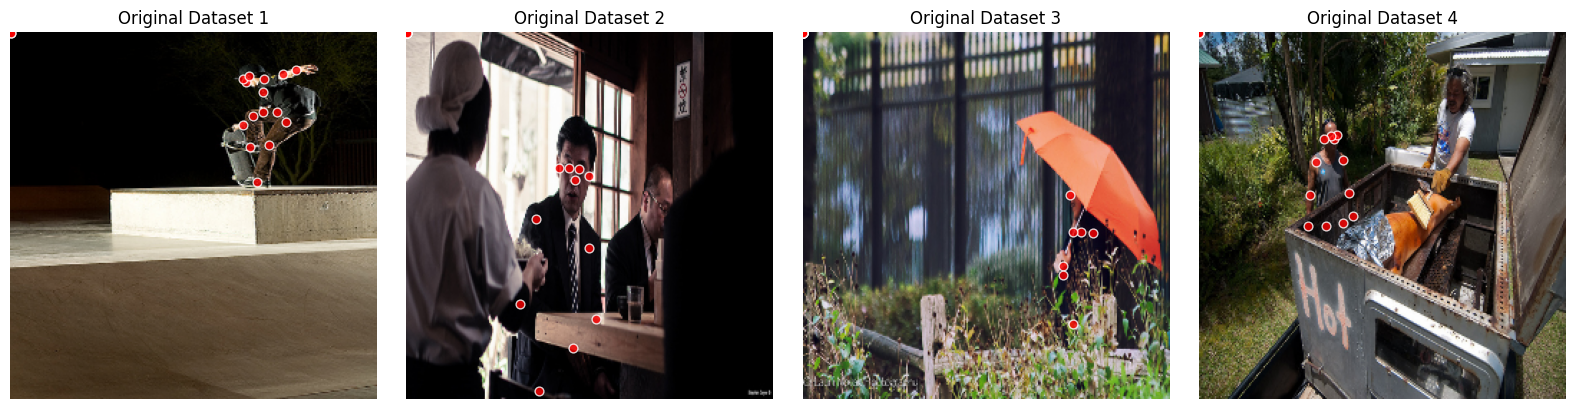

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


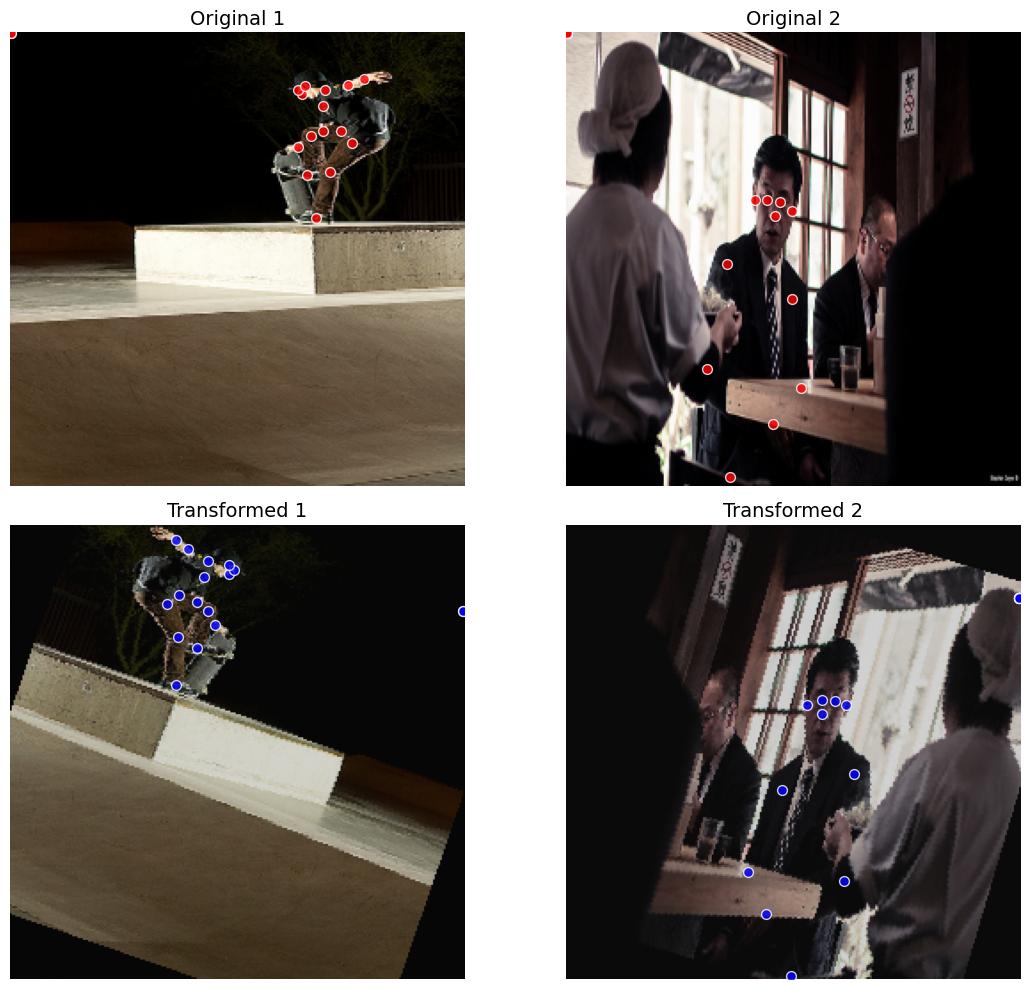

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


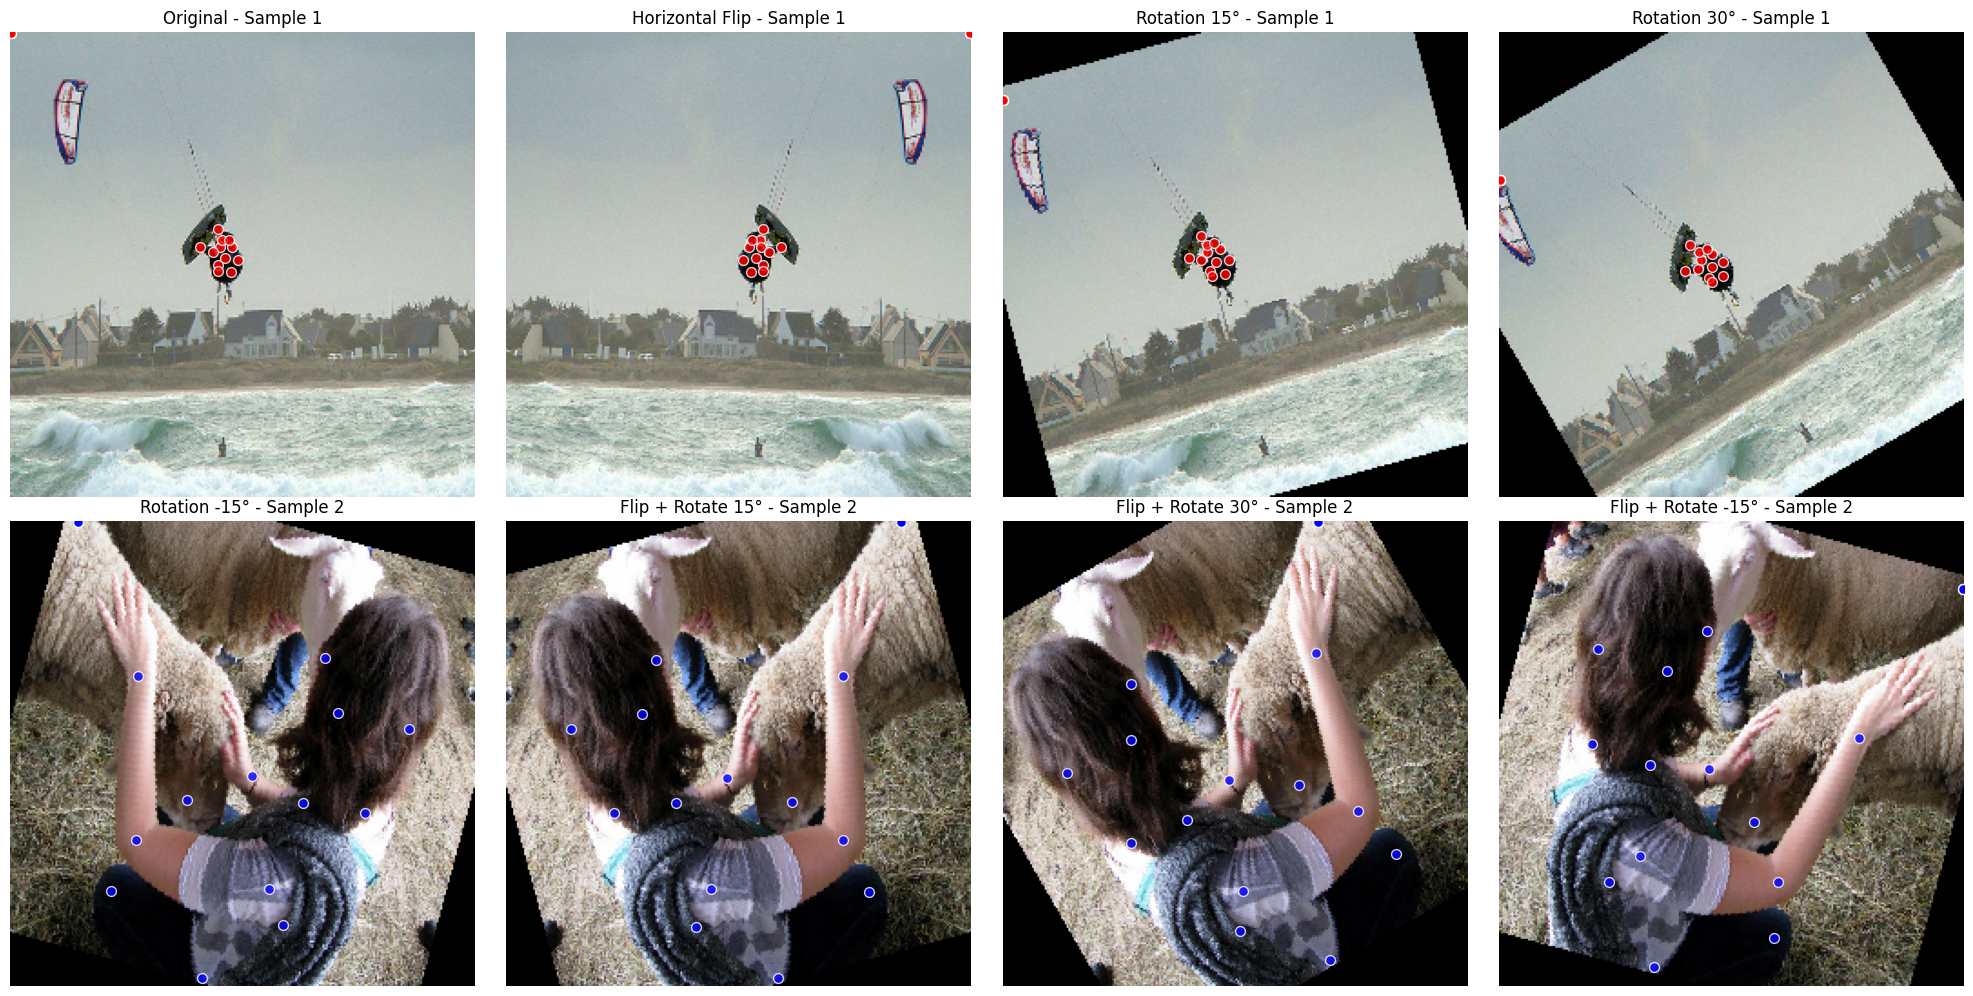

In [18]:
def execute_pipeline():
    if not all([setup_success, data_success, dataset_success, transform_success, visualization_success]):
        return False

    train_loader = get_dataloader(train_ann_file, train_images_dir, batch_size=4)
    val_loader = get_dataloader(val_ann_file, val_images_dir, batch_size=4)

    visualize_basic_batch(val_loader, "Original Dataset")
    visualize_augmentation_comparison()
    visualize_debug_transformations()

    return True

pipeline_success = execute_pipeline()